# Notebook for reproducing the reported results for MTL and STL models using random undersampling of the logP training set

In [11]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, t
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from modules.plotting import confidence_interval
import os

In [2]:
#set some parameters
sizes = [0.01,0.05, 0.1, 0.25, 0.5, 0.75, 1]
out_dir = 'LogP_different_sizes/'
# os.makedirs(out_dir, exist_ok=True)

In [3]:
#load data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

stl_test = test[["SMILES", "LogP"]].dropna()
stl_data = train[["SMILES", "LogP"]].dropna()

## train the models using various sizes, and random seeds for different random undersampling of the data

In [4]:
for seed in range(3):
    stl_data_shuffled = stl_data.sample(frac=1, random_state=seed)  # Shuffle data with different random seeds
    other_properties = train.drop(columns="LogP")
    for s in sizes:
        #check if outfle exists, if so, skip
        if os.path.exists(out_dir + f'seed_{seed}/{s}_MTL/preds_0.csv'):
            print(f'seed_{seed}/{s}_STL/preds_0.csv exists, skipping')
            continue

        os.makedirs(out_dir + f'seed_{seed}/{s}_STL', exist_ok=True)
        stl_less_data = stl_data_shuffled[:int(len(stl_data_shuffled)*s)]
        print("frac", s, ":", len(stl_less_data))   
        stl_less_data.to_csv(out_dir + f'seed_{seed}/{s}_STL/train.csv', index=False)
        stl_test.to_csv(out_dir + f'seed_{seed}/{s}_STL/test.csv', index=False)
        os.makedirs(out_dir + f'seed_{seed}/{s}_MTL', exist_ok=True)
        mtl_less_data = pd.merge(stl_less_data, other_properties, on="SMILES", how="outer")
        mtl_less_data.to_csv(out_dir + f'seed_{seed}/{s}_MTL/train.csv', index=False)
        test.to_csv(out_dir + f'seed_{seed}/{s}_MTL/test.csv', index=False)
        properties = mtl_less_data.drop(columns='SMILES').columns.to_list()
        # train STL
        os.system(f'''chemprop train \
        --data-path {out_dir}seed_{seed}/{s}_STL/train.csv \
        --task-type regression \
        --output-dir {out_dir}seed_{seed}/{s}_STL/model/ \
        --num-workers 15 > /dev/null 2>&1''')
        
        # Predict
        os.system(f'''chemprop predict \
        --test-path {out_dir}seed_{seed}/{s}_STL/test.csv \
        --model-path {out_dir}seed_{seed}/{s}_STL/model/model_0/best.pt \
        --preds-path {out_dir}seed_{seed}/{s}_STL/preds.csv \
        --num-workers 15 > /dev/null 2>&1''')

        # train MTL
        os.system(f'''chemprop train \
        --data-path {out_dir}seed_{seed}/{s}_MTL/train.csv \
        --task-type regression \
        --target-columns {" ".join(properties)} \
        --task-weights {" ".join([str(1) if p != "LogP" else str(10) for p in properties])} \
        --output-dir {out_dir}seed_{seed}/{s}_MTL/model/ \
        --num-workers 15 > /dev/null 2>&1''')

        # Predict
        os.system(f'''chemprop predict \
        --test-path {out_dir}seed_{seed}/{s}_MTL/test.csv \
        --model-path {out_dir}seed_{seed}/{s}_MTL/model/model_0/best.pt \
        --preds-path {out_dir}seed_{seed}/{s}_MTL/preds.csv \
        --num-workers 15 > /dev/null 2>&1''')


seed_0/0.01_STL/preds_0.csv exists, skipping
seed_0/0.05_STL/preds_0.csv exists, skipping
seed_0/0.1_STL/preds_0.csv exists, skipping
seed_0/0.25_STL/preds_0.csv exists, skipping
seed_0/0.5_STL/preds_0.csv exists, skipping
seed_0/0.75_STL/preds_0.csv exists, skipping
seed_0/1_STL/preds_0.csv exists, skipping
seed_1/0.01_STL/preds_0.csv exists, skipping
seed_1/0.05_STL/preds_0.csv exists, skipping
seed_1/0.1_STL/preds_0.csv exists, skipping
seed_1/0.25_STL/preds_0.csv exists, skipping
seed_1/0.5_STL/preds_0.csv exists, skipping
seed_1/0.75_STL/preds_0.csv exists, skipping
seed_1/1_STL/preds_0.csv exists, skipping
seed_2/0.01_STL/preds_0.csv exists, skipping
seed_2/0.05_STL/preds_0.csv exists, skipping
seed_2/0.1_STL/preds_0.csv exists, skipping
seed_2/0.25_STL/preds_0.csv exists, skipping
seed_2/0.5_STL/preds_0.csv exists, skipping
seed_2/0.75_STL/preds_0.csv exists, skipping
seed_2/1_STL/preds_0.csv exists, skipping


## Load the data and plot metrics

/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/localhome/cschiebroek/.conda/envs/chemprop/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarnin

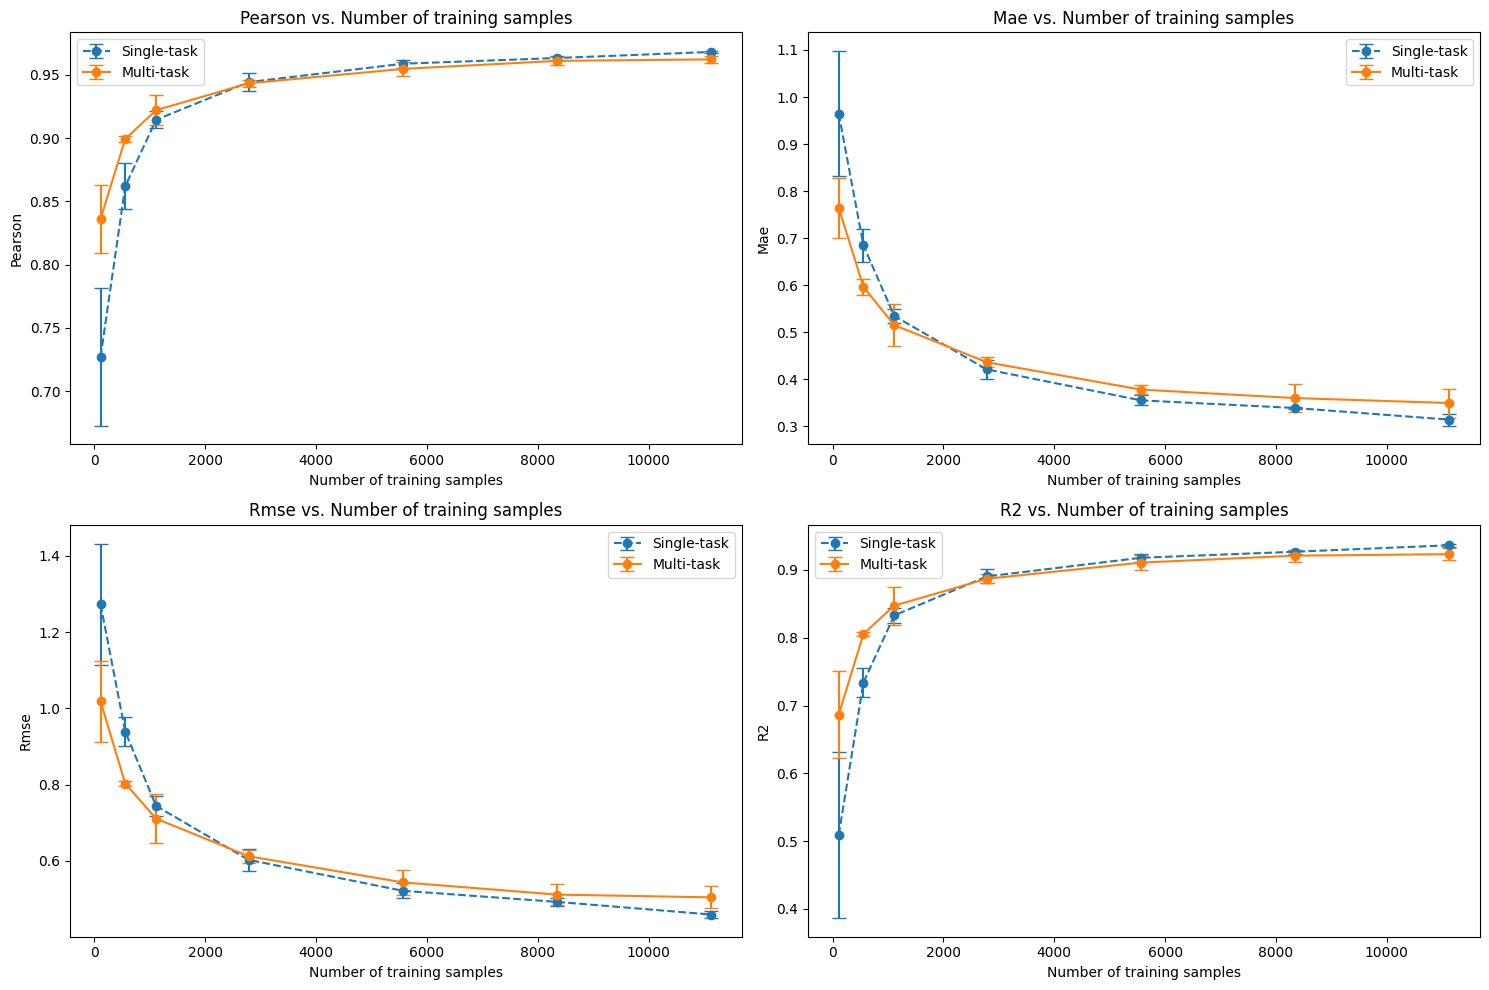

In [5]:
# Initialize dictionary to store results
metrics = ["pearson", "mae", "rmse", "r2"]
results = {metric: {s: {"single_task": [], "multi_task": []} for s in sizes} for metric in metrics}

# Collect metrics for each dataset size and each seed
for seed in range(3):
    for s in sizes:
        # Prepare data for single-task
        single_task_df = pd.read_csv(out_dir + f'seed_{seed}/{s}_STL/preds_0.csv')
        valid_single = single_task_df[['SMILES', "LogP", 'pred_0']].dropna()
        true_single_values = valid_single["LogP"]
        pred_single_values = valid_single['pred_0']

        # Prepare data for multi-task
        multi_task_df = pd.read_csv(out_dir + f'seed_{seed}/{s}_MTL/preds_0.csv')
        valid_multi = multi_task_df[['SMILES', "LogP", 'pred_0']].dropna()
        true_multi_values = valid_multi["LogP"]
        pred_multi_values = valid_multi['pred_0']

        # Calculate metrics and store results
        results["pearson"][s]["single_task"].append(pearsonr(true_single_values, pred_single_values)[0])
        results["mae"][s]["single_task"].append(mean_absolute_error(true_single_values, pred_single_values))
        results["rmse"][s]["single_task"].append(mean_squared_error(true_single_values, pred_single_values, squared=False))
        results["r2"][s]["single_task"].append(r2_score(true_single_values, pred_single_values))

        results["pearson"][s]["multi_task"].append(pearsonr(true_multi_values, pred_multi_values)[0])
        results["mae"][s]["multi_task"].append(mean_absolute_error(true_multi_values, pred_multi_values))
        results["rmse"][s]["multi_task"].append(mean_squared_error(true_multi_values, pred_multi_values, squared=False))
        results["r2"][s]["multi_task"].append(r2_score(true_multi_values, pred_multi_values))

# Calculate mean and confidence intervals for each metric
aggregated_results = {metric: [] for metric in metrics}

for metric in metrics:
    for s in sizes:
        single_mean, single_lower, single_upper = confidence_interval(results[metric][s]["single_task"])
        multi_mean, multi_lower, multi_upper = confidence_interval(results[metric][s]["multi_task"])
        aggregated_results[metric].append([s, single_mean, single_lower, single_upper, multi_mean, multi_lower, multi_upper])

# Convert results to DataFrames
dfs = {metric: pd.DataFrame(aggregated_results[metric], columns=["Size", "Single-task mean", "Single-task lower CI", "Single-task upper CI",
                                                                 "Multi-task mean", "Multi-task lower CI", "Multi-task upper CI"]) for metric in metrics}

# Plotting the results
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for ax, (metric, df) in zip(axs.flatten(), dfs.items()):
    ax.errorbar(df["Size"] * len(stl_data), df["Single-task mean"],
                yerr=[df["Single-task mean"] - df["Single-task lower CI"],
                      df["Single-task upper CI"] - df["Single-task mean"]],
                label="Single-task", fmt='o', capsize=5,ls='--')
    ax.errorbar(df["Size"] * len(stl_data), df["Multi-task mean"],
                yerr=[df["Multi-task mean"] - df["Multi-task lower CI"],
                      df["Multi-task upper CI"] - df["Multi-task mean"]],
                label="Multi-task", fmt='o', ls='-', capsize=5)
    ax.set_xlabel("Number of training samples")
    ax.set_ylabel(metric.capitalize().replace("_", " "))
    ax.legend()
    ax.set_title(f'{metric.capitalize().replace("_", " ")} vs. Number of training samples')

plt.tight_layout()
plt.show()



## Plot pearson as in report

/tmp/ipykernel_2076377/2637932354.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/tmp/ipykernel_2076377/2637932354.py:33: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  ax.errorbar(
/tmp/ipykernel_2076377/2637932354.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(x)}' for x in ax.get_xticks()], fontsize=ticklabelsize)
/tmp/ipykernel_2076377/2637932354.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{x:.2f}' for x in ax.get_yticks()], fontsize=ticklabelsize)


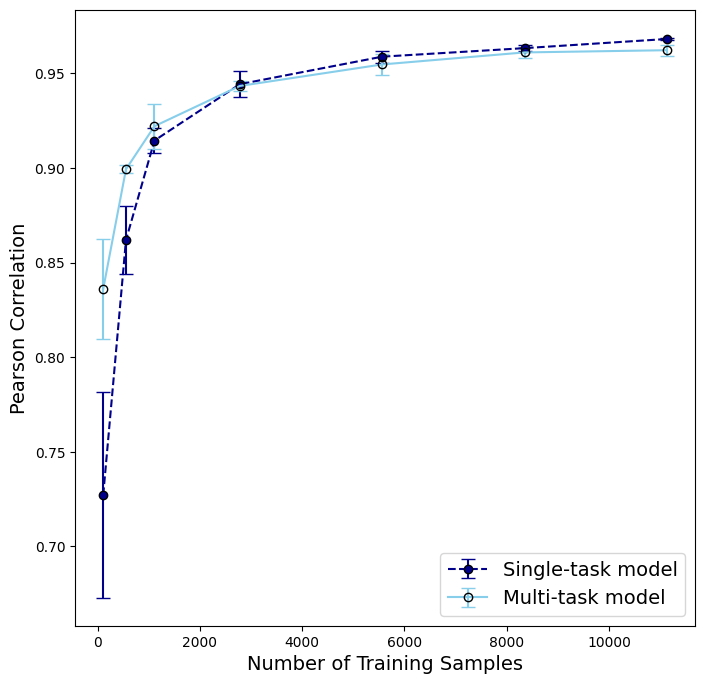

In [6]:
# Data preparation (assuming dfs and stl_data are predefined)
pearson_df = dfs["pearson"]

# Plot settings
fig, ax = plt.subplots(figsize=(8, 8))
ticklabelsize = 10
axislabelsize = 14
legend_fontsize = 14

# Plotting Single-task model
ax.errorbar(
    pearson_df["Size"] * len(stl_data),
    pearson_df["Single-task mean"],
    yerr=[
        pearson_df["Single-task mean"] - pearson_df["Single-task lower CI"],
        pearson_df["Single-task upper CI"] - pearson_df["Single-task mean"]
    ],
    label="Single-task model",
    fmt='o',  # circle marker
    capsize=5,  # size of the caps on error bars
    linestyle='--',  # dashed line
    color='darkblue',  # change color to reds
    marker='o',
    #change color of edge
    markeredgecolor = 'black'


)

# Plotting Multi-task model
ax.errorbar(
    pearson_df["Size"] * len(stl_data),
    pearson_df["Multi-task mean"],
    yerr=[
        pearson_df["Multi-task mean"] - pearson_df["Multi-task lower CI"],
        pearson_df["Multi-task upper CI"] - pearson_df["Multi-task mean"]
    ],
    label="Multi-task model",
    fmt='s',  # square marker
    capsize=5,  # size of the caps on error bars
    linestyle='-',  # solid line
    fillstyle='none',  # no fill for the marker\
    color='skyblue' , # change color to reds
    marker='o',
    markeredgecolor='black'
)

# Labeling axes
ax.set_xlabel("Number of Training Samples", fontsize=axislabelsize)
ax.set_ylabel("Pearson Correlation", fontsize=axislabelsize)

# Formatting tick labels
ax.set_xticklabels([f'{int(x)}' for x in ax.get_xticks()], fontsize=ticklabelsize)
ax.set_yticklabels([f'{x:.2f}' for x in ax.get_yticks()], fontsize=ticklabelsize)

# Adding legend
ax.legend(loc="lower right", fontsize=legend_fontsize)
fig.savefig("pearson_correlation.png", dpi=800)


## Evaluation on external test set (SAMPL6)

In [ ]:
# Predict using STL model
import os
os.system(f'''chemprop predict \
--test-path "sampl_logP.csv" \
--model-path LogP_different_sizes/seed_0/1_MTL/model/model_0/best.pt \
--preds-path "SAMPL_STL_preds.csv" \
--num-workers 15''')

# Predict using MTL model
os.system(f'''chemprop predict \
--test-path "sampl_logP.csv" \
--model-path LogP_different_sizes/seed_0/1_STL/model/model_0/best.pt \
--preds-path "SAMPL_MTL_preds.csv" \
--num-workers 15''')

In [7]:
results_mtl = pd.read_csv('SAMPL_MTL_preds_0.csv')
results_stl = pd.read_csv('SAMPL_STL_preds_0.csv')

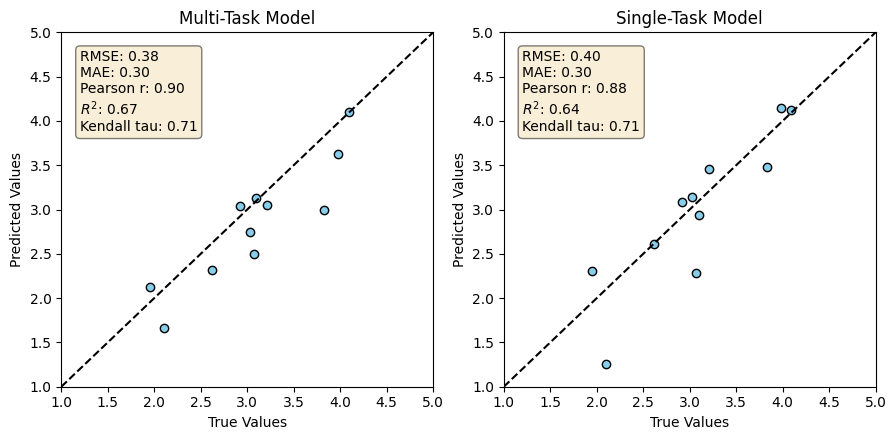

In [8]:
# Create a figure and two subplots
fig, axs = plt.subplots(1, 2, figsize=(9, 4.5))

# Set axis limits
xlim = ylim = (1, 5)

# First scatter plot
axs[0].scatter(results_mtl['LogP'], results_mtl['pred_0'], edgecolor='black', color='skyblue')
# Set limits for the plot
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)
# Add diagonal line
axs[0].plot(xlim, ylim, 'k--')
# Calculate statistics
rmse = np.sqrt(mean_squared_error(results_mtl['LogP'], results_mtl['pred_0']))
mae = mean_absolute_error(results_mtl['LogP'], results_mtl['pred_0'])
r, _ = pearsonr(results_mtl['LogP'], results_mtl['pred_0'])
r2 = r2_score(results_mtl['LogP'], results_mtl['pred_0'])
tau, _ = kendalltau(results_mtl['LogP'], results_mtl['pred_0'])
textstr = f'RMSE: {rmse:.2f}\nMAE: {mae:.2f}\nPearson r: {r:.2f}\n$R^2$: {r2:.2f}\nKendall tau: {tau:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axs[0].text(0.05, 0.95, textstr, transform=axs[0].transAxes, fontsize=10, verticalalignment='top', bbox=props)

axs[0].set_xlabel('True Values')
axs[0].set_ylabel('Predicted Values')
axs[0].set_title('Multi-Task Model')

# Second scatter plot
axs[1].scatter(results_stl['LogP'], results_stl['pred_0'], edgecolor='black', color='skyblue')
# Set limits for the plot
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)
# Add diagonal line
axs[1].plot(xlim, ylim, 'k--')
# Calculate statistics
rmse = np.sqrt(mean_squared_error(results_stl['LogP'], results_stl['pred_0']))
mae = mean_absolute_error(results_stl['LogP'], results_stl['pred_0'])
r, _ = pearsonr(results_stl['LogP'], results_stl['pred_0'])
r2 = r2_score(results_stl['LogP'], results_stl['pred_0'])
tau, _ = kendalltau(results_stl['LogP'], results_stl['pred_0'])
textstr = f'RMSE: {rmse:.2f}\nMAE: {mae:.2f}\nPearson r: {r:.2f}\n$R^2$: {r2:.2f}\nKendall tau: {tau:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axs[1].text(0.05, 0.95, textstr, transform=axs[1].transAxes, fontsize=10, verticalalignment='top', bbox=props)

axs[1].set_xlabel('True Values')
axs[1].set_ylabel('Predicted Values')
axs[1].set_title('Single-Task Model')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


## Evaluation on external test set with undersampling (1%)

In [15]:
# Predict using STL model
os.system(f'''chemprop predict \
--test-path "sampl_logP.csv" \
--model-path LogP_different_sizes/seed_0/0.01_STL/model/model_0/best.pt \
--preds-path "SAMPL_STL_preds_undersampling.csv" \
--num-workers 15 > /dev/null 2>&1''')

# Predict using MTL model
os.system(f'''chemprop predict \
--test-path "sampl_logP.csv" \
--model-path LogP_different_sizes/seed_0/0.01_MTL/model/model_0/best.pt \
--preds-path "SAMPL_MTL_preds_undersampling.csv" \
--num-workers 15 > /dev/null 2>&1''')

0

In [16]:
results_mtl = pd.read_csv('SAMPL_MTL_preds_undersampling_0.csv')
results_stl = pd.read_csv('SAMPL_STL_preds_undersampling_0.csv')

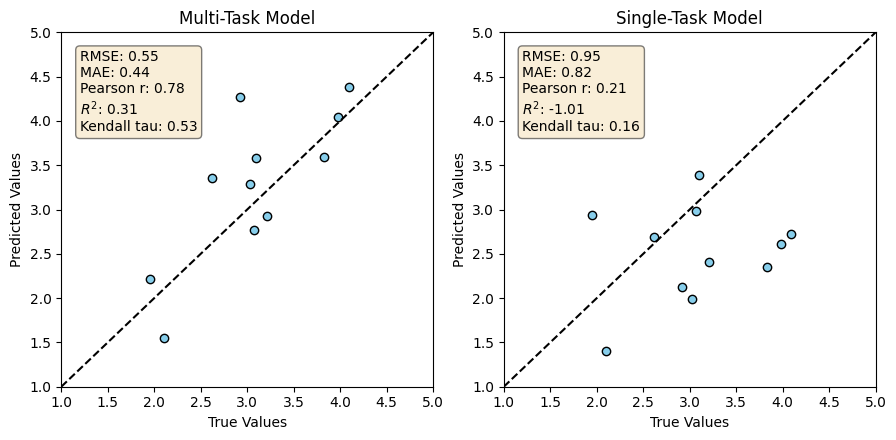

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, kendalltau

# Create a figure and two subplots
fig, axs = plt.subplots(1, 2, figsize=(9, 4.5))

# Set axis limits
xlim = ylim = (1, 5)

# First scatter plot
axs[0].scatter(results_mtl['LogP'], results_mtl['pred_0'], edgecolor='black', color='skyblue')
# Set limits for the plot
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)
# Add diagonal line
axs[0].plot(xlim, ylim, 'k--')
# Calculate statistics
rmse = np.sqrt(mean_squared_error(results_mtl['LogP'], results_mtl['pred_0']))
mae = mean_absolute_error(results_mtl['LogP'], results_mtl['pred_0'])
r, _ = pearsonr(results_mtl['LogP'], results_mtl['pred_0'])
r2 = r2_score(results_mtl['LogP'], results_mtl['pred_0'])
tau, _ = kendalltau(results_mtl['LogP'], results_mtl['pred_0'])
textstr = f'RMSE: {rmse:.2f}\nMAE: {mae:.2f}\nPearson r: {r:.2f}\n$R^2$: {r2:.2f}\nKendall tau: {tau:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axs[0].text(0.05, 0.95, textstr, transform=axs[0].transAxes, fontsize=10, verticalalignment='top', bbox=props)

axs[0].set_xlabel('True Values')
axs[0].set_ylabel('Predicted Values')
axs[0].set_title('Multi-Task Model')

# Second scatter plot
axs[1].scatter(results_stl['LogP'], results_stl['pred_0'], edgecolor='black', color='skyblue')
# Set limits for the plot
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)
# Add diagonal line
axs[1].plot(xlim, ylim, 'k--')
# Calculate statistics
rmse = np.sqrt(mean_squared_error(results_stl['LogP'], results_stl['pred_0']))
mae = mean_absolute_error(results_stl['LogP'], results_stl['pred_0'])
r, _ = pearsonr(results_stl['LogP'], results_stl['pred_0'])
r2 = r2_score(results_stl['LogP'], results_stl['pred_0'])
tau, _ = kendalltau(results_stl['LogP'], results_stl['pred_0'])
textstr = f'RMSE: {rmse:.2f}\nMAE: {mae:.2f}\nPearson r: {r:.2f}\n$R^2$: {r2:.2f}\nKendall tau: {tau:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axs[1].text(0.05, 0.95, textstr, transform=axs[1].transAxes, fontsize=10, verticalalignment='top', bbox=props)

axs[1].set_xlabel('True Values')
axs[1].set_ylabel('Predicted Values')
axs[1].set_title('Single-Task Model')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
